[*********************100%***********************]  5 of 5 completed
/var/folders/k1/7yl62fwx2879_758cjywcjrw0000gn/T/ipykernel_54732/1859653868.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr = (cumulative[-1] ** (1/years)) - 1


Performance Metrics:
                    CAGR  Volatility  Sharpe Ratio  Max Drawdown
Mean-Variance  0.084174    0.164646      0.451759     -0.254851
Max Return     0.109432    0.260587      0.452533     -0.403696
Min Variance   0.110700    0.167503      0.591530     -0.335009
Max Sharpe     0.126459    0.222735      0.556792     -0.319145


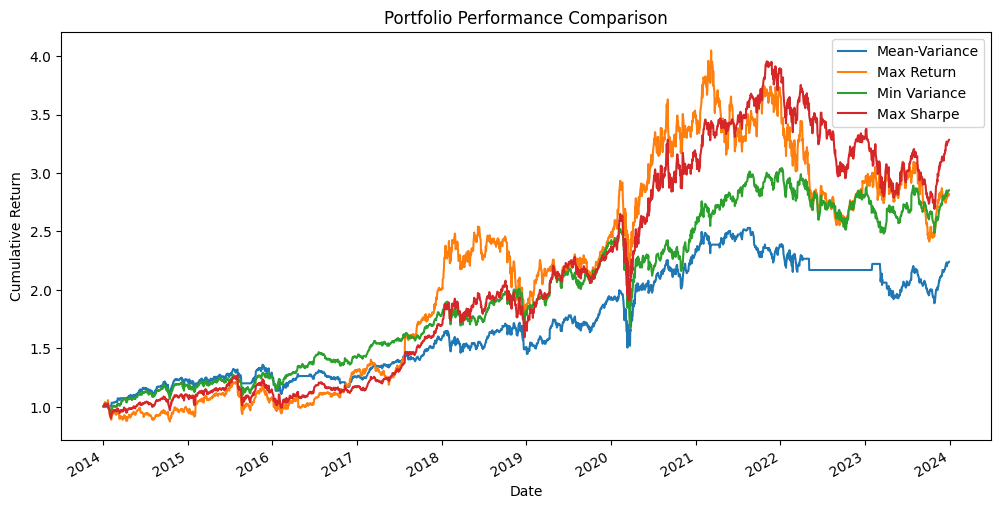

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Download and prepare data
symbols = ['MSFT', 'JNJ', 'JPM', 'DIS', 'BA']
start_date = '2013-01-01'
end_date = '2024-01-01'

data = yf.download(symbols, start_date, end_date, auto_adjust=False)['Adj Close']
data = data.interpolate(method='linear')
returns = data.pct_change().dropna()

# Set parameters
window_size = 252  # 1 year rolling window
risk_free_rate = 0.02  # Annual risk-free rate
target_return = 0.20  # For mean-variance strategy

# Initialize results DataFrame
strategies = ['Mean-Variance', 'Max Return', 'Min Variance', 'Max Sharpe']
portfolio_returns = pd.DataFrame(index=returns.index[window_size:], columns=strategies)

def optimize_portfolio(current_returns, strategy, Sigma=None, mu=None):
    n_assets = len(current_returns.columns)
    bounds = tuple((0.0, 1.0) for _ in range(n_assets))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    if strategy == 'Min Variance':
        def objective(w): return w @ Sigma @ w
        result = minimize(objective, np.ones(n_assets)/n_assets, 
                        method='SLSQP', bounds=bounds, constraints=constraints)
        
    elif strategy == 'Mean-Variance':
        def objective(w): return w @ Sigma @ w
        constraints = (
            {'type': 'eq', 'fun': lambda w: w @ mu - target_return},
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
        )
        result = minimize(objective, np.ones(n_assets)/n_assets,
                        method='SLSQP', bounds=bounds, constraints=constraints)
        
    elif strategy == 'Max Sharpe':
        def objective(w): 
            portfolio_return = w @ mu
            portfolio_vol = np.sqrt(w @ Sigma @ w)
            return -(portfolio_return - risk_free_rate/252) / portfolio_vol
        result = minimize(objective, np.ones(n_assets)/n_assets,
                        method='SLSQP', bounds=bounds, constraints=constraints)
        
    elif strategy == 'Max Return':
        return (np.eye(n_assets)[np.argmax(mu)],)
    
    return result.x if result.success else np.zeros(n_assets)

# Rolling window implementation
for i in range(window_size, len(returns)):
    train_data = returns.iloc[i-window_size:i]
    
    mu = train_data.mean() * 252
    Sigma = train_data.cov() * 252
    
    # Skip invalid windows
    if mu.isna().any() or Sigma.isnull().values.any():
        continue
        
    # Calculate weights for each strategy
    weights = {
        'Mean-Variance': optimize_portfolio(train_data, 'Mean-Variance', Sigma, mu),
        'Max Return': np.eye(len(mu))[np.argmax(mu)],
        'Min Variance': optimize_portfolio(train_data, 'Min Variance', Sigma, mu),
        'Max Sharpe': optimize_portfolio(train_data, 'Max Sharpe', Sigma, mu)
    }
    
    # Get next day's returns
    next_return = returns.iloc[i].values
    
    # Store portfolio returns
    for strategy in strategies:
        portfolio_returns.loc[returns.index[i], strategy] = np.dot(weights[strategy], next_return)

# Performance metrics calculation
def calculate_metrics(returns_series):
    cumulative = (1 + returns_series).cumprod()
    years = (returns_series.index[-1] - returns_series.index[0]).days / 365.25
    
    # CAGR
    cagr = (cumulative[-1] ** (1/years)) - 1
    
    # Annual volatility
    annual_vol = returns_series.std() * np.sqrt(252)
    
    # Sharpe ratio
    sharpe = (returns_series.mean() * 252 - risk_free_rate) / annual_vol
    
    # Max drawdown
    peak = cumulative.expanding().max()
    drawdown = (cumulative - peak) / peak
    max_dd = drawdown.min()
    
    return pd.Series({
        'CAGR': cagr,
        'Volatility': annual_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd
    })

# Generate results
results = portfolio_returns.apply(calculate_metrics)
print("Performance Metrics:\n", results.T)

# Plot cumulative returns
(1 + portfolio_returns).cumprod().plot(figsize=(12,6), title='Portfolio Performance Comparison')
plt.ylabel('Cumulative Return')
plt.show()